# ML Classification

In [1]:
# Imports
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from data_loading import demographics, weather, rats, geography

data_folder_path = "C:/Users/jerom/OneDrive/Documents/Uni/MGI/RS and GIS integration/ACT Python Environment/Data/"

rat_df = rats.load_rm_data(data_folder_path + "Rat_Monitor_export.xlsx")
pc_rat_df = rats.group_by_postcode(rat_df)
month_rat_df = rats.group_by_month(rat_df)

cbs_df = demographics.load_cbs_data(data_folder_path + "cbs_pc4_2024_v1.gpkg", drop_empty_cols=True)
month_temp_df = weather.load_cnt_data(data_folder_path + "cnt.dat")
bins_df = geography.load_bin_data(data_folder_path + "PC4_areas_bak_put_water.csv")
manholes_df = geography.load_manhole_data(data_folder_path + "PC4_areas_bak_put_water.csv")

c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\act2025webapp\data_exploration\data_loading\weather.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cnt_df = pd.read_csv(path, delim_whitespace=True, skiprows=8, names=col_names)


In [6]:
# Set features to exclude in ML
exclude_features = ['TOTAAL', 'area_km2', 'geometry', 'stedelijkheid', 'EEN_OF_MEER', 'MEER_DAN_VIJF']

In [7]:
from data_loading import ml

# Merge data and prepare features
cbs_df = demographics.drop_empty_cols(cbs_df, max_na_percentage=0.05)
cbs_df = demographics.aantal_to_percentage(cbs_df)
ml_merged_df = ml.merge_data(pc_rat_df, [cbs_df, bins_df, manholes_df], dropna=True)

X, y = ml.prepare_clf_data(ml_merged_df, 'TOTAAL', exclude_features=exclude_features)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


## SVM

In [8]:
# Train and evaluate a Support Vector Machine (SVM) classifier
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

# Predict and evaluate
y_pred_svc = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))

[[830   0]
 [139   0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       830
           1       0.00      0.00      0.00       139

    accuracy                           0.86       969
   macro avg       0.43      0.50      0.46       969
weighted avg       0.73      0.86      0.79       969



c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0

In [9]:
# Hyperparameter cross-validation for Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
[[818  12]
 [135   4]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       830
           1       0.25      0.03      0.05       139

    accuracy                           0.85       969
   macro avg       0.55      0.51      0.48       969
weighted avg       0.77      0.85      0.79       969



In [10]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Train Balanced Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

brf = BalancedRandomForestClassifier(random_state=42)
grid_search = GridSearchCV(brf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

clf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
[[647 183]
 [ 79  60]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       830
           1       0.25      0.43      0.31       139

    accuracy                           0.73       969
   macro avg       0.57      0.61      0.57       969
weighted avg       0.80      0.73      0.76       969



In [11]:
import xgboost as xgb

# Define parameter grid for cross-validation
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

c:\Users\jerom\OneDrive\Documents\Uni\MGI\RS and GIS integration\ACT Python Environment\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:38:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
[[805  25]
 [126  13]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       830
           1       0.34      0.09      0.15       139

    accuracy                           0.84       969
   macro avg       0.60      0.53      0.53       969
weighted avg       0.79      0.84      0.80       969



##### Plot

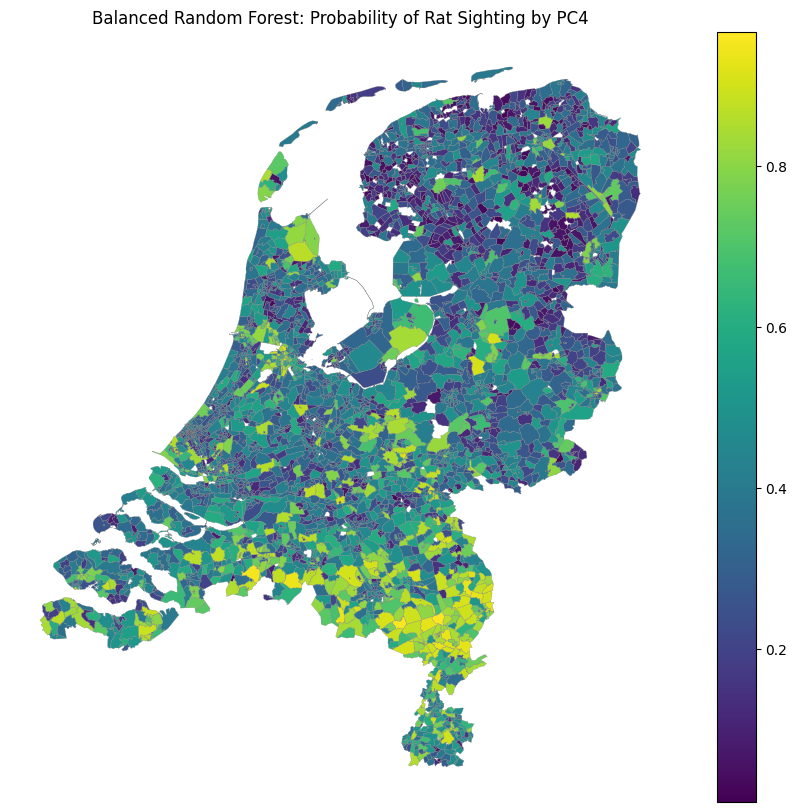

In [12]:
# Predict rat sighting for all PC4s in cbs_df using the trained BalancedRandomForestClassifier (brf)
# Use the same features as used for training (exclude_features)
ml_plot_df = gpd.GeoDataFrame(ml_merged_df)
X_map = ml_plot_df.drop(columns=exclude_features)
proba_map = clf.predict_proba(X_map)[:, 1]  # Probability of class 1

ml_plot_df['prob_positive'] = proba_map

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ml_plot_df.plot(
    column='prob_positive',
    cmap='viridis',
    linewidth=0.2,
    edgecolor='grey',
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)
ax.set_title('Balanced Random Forest: Probability of Rat Sighting by PC4')
ax.axis('off')
plt.show()

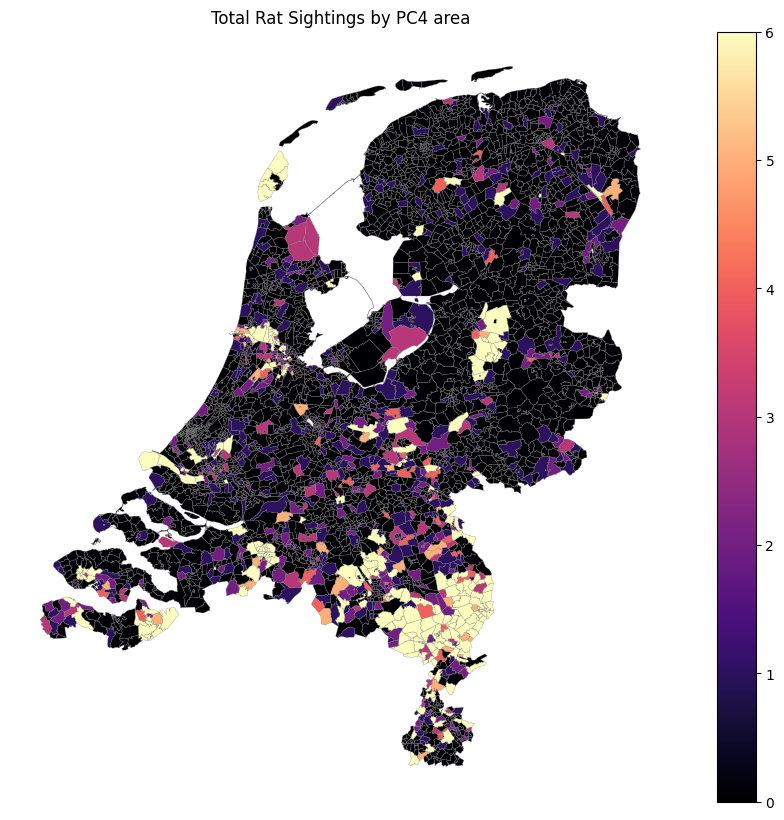

In [19]:
# Ensure indices are int and aligned
cbs_df.index = cbs_df.index.astype(int)
pc_rat_df.index = pc_rat_df.index.astype(int)

# Join rat stats into CBS GeoDataFrame
map_gdf = cbs_df.join(pc_rat_df, how='left')
map_gdf['TOTAAL'] = map_gdf['TOTAAL'].fillna(0)

# Plot map with color scale focused on lower end
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
vmax = map_gdf['TOTAAL'].quantile(0.95)  # focus color scale on lower 95 percent
map_gdf.plot(
    column='TOTAAL',
    cmap='magma',
    linewidth=0.2,
    edgecolor='grey',
    legend=True,
    ax=ax,
    vmin=0,
    vmax=vmax,
    missing_kwds={
        "color": "lightgrey",
        "label": "No data"
    }
)
ax.set_title('Total Rat Sightings by PC4 area')
ax.axis('off')
plt.show()

#### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop non-numeric columns and NaNs for PCA
X_pca = cbs_rat_ml_df.drop(columns=exclude_features).select_dtypes(include=[np.number]).dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Fit PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=X_pca.index)

# Explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Show the first few rows
pca_df.head()

Explained variance ratio: [0.3489551  0.11217969]


,PC1,PC2
postcode,,
1011,-10.274113,-4.004678
1012,-12.218605,-6.274296
1013,-10.923232,-0.028368
1015,-12.907727,-3.676924
1016,-11.941657,-5.213189


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

pca_df = pca_df.join(y, on='postcode', how='right')

# Align indices and join with target
X_pca_rf = pca_df.drop('TOTAAL', axis=1)
y_pca_rf = pca_df['TOTAAL']

# Train/test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_rf, y_pca_rf, stratify=y_pca_rf, random_state=42
)

# Train Random Forest
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train_pca)

# Predict and evaluate 
y_pred_pca = rf_pca.predict(X_test_pca)
print(confusion_matrix(y_test_pca, y_pred_pca))
print(classification_report(y_test_pca, y_pred_pca))

[[149  19]
 [ 54  15]]
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       168
           1       0.44      0.22      0.29        69

    accuracy                           0.69       237
   macro avg       0.59      0.55      0.55       237
weighted avg       0.65      0.69      0.65       237



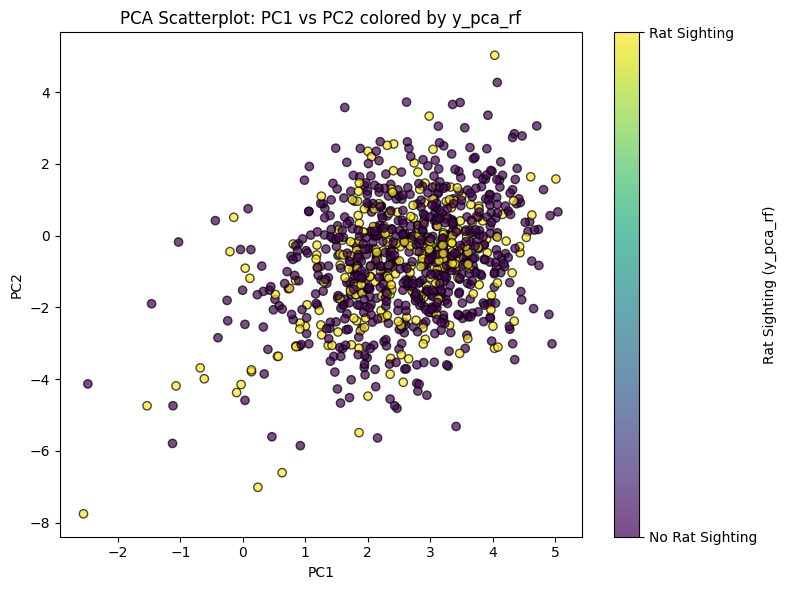

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=y_pca_rf, 
    cmap='viridis', 
    alpha=0.7, 
    edgecolor='k'
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Scatterplot: PC1 vs PC2 colored by y_pca_rf')
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Rat Sighting', 'Rat Sighting'])
cbar.set_label('Rat Sighting (y_pca_rf)')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [300, 500],
    'alpha': [0.0001, 0.001]
}

mlp = MLPClassifier(random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

mlp = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = mlp.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'max_iter': 300, 'solver': 'adam'}
[[115  53]
 [ 31  38]]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       168
           1       0.42      0.55      0.47        69

    accuracy                           0.65       237
   macro avg       0.60      0.62      0.60       237
weighted avg       0.68      0.65      0.66       237

